# Dimensionality Reduction

Dimensionality reduction is a technique used in machine learning and statistics to reduce the number of input variables in a dataset. More input features often make a model more complex, increasing the risk of overfitting and making the model harder to interpret. Dimensionality reduction techniques aim to simplify models without losing much information.

---

### Why is Dimensionality Reduction Important?

1. **Simplification**: Makes the dataset easier to explore and visualize.
2. **Speed**: Reduces the computational complexity, making algorithms run faster.
3. **Data Compression**: Allows for more efficient storage of data.
4. **Noise Reduction**: Helps to eliminate irrelevant features or reduce noise.
5. **Improved Performance**: Can lead to better model performance when irrelevant features are removed.

---

### Example: Customer Segmentation in Retail

Imagine you're a data scientist at a retail company. The company collects data on customer transactions, online activity, customer service interactions, and more. In total, you have hundreds of features for each customer.

**The Problem**: You want to segment your customer base to target marketing more effectively, but the high dimensionality of your data makes it difficult to gain any meaningful insights.

**The Solution**: By applying dimensionality reduction techniques like PCA, you can reduce your hundreds of features to just a few principal components. These components can effectively summarize the essential information in the dataset, making it easier to perform customer segmentation.

**Outcome**: The marketing team can now more effectively tailor strategies for different segments, thereby increasing customer engagement and revenue.

## Overview

1. The curse of dimensionality
2. PCA
3. Factor Analysis
4. Adaptive Methods: t-SNE and UMAP
5. Other techniques and resources

---

# The Curse of Dimensionality

 In high dimensions, the behavior of data can be counterintuitive, and algorithms that work well in low dimensions can become ineffective or computationally expensive.  This is because the available "space" that training samples are embedded grows exponentially with respect to the data.  This has several ramifications:

 - Distances between items become larger
 - Difference between distances become smaller
 - The amount of data required to cover the space grows exponentially

### The Hughes Phenomenon ###

The Hughes Phenomenon shows that as the number of features increases, the classifier’s performance increases as well until we reach the optimal number of features. Adding more features based on the same size as the training set will then degrade the classifier’s performance.

![The Hughes Phenomenon](./assets/hughes_phenomenon.png)

See [this explanation](https://www.visiondummy.com/2014/04/curse-dimensionality-affect-classification/) to help guide your intuitions.

---

### Experiments with dimensionality

The following code illustrates how increasing dimensionality increases distance.

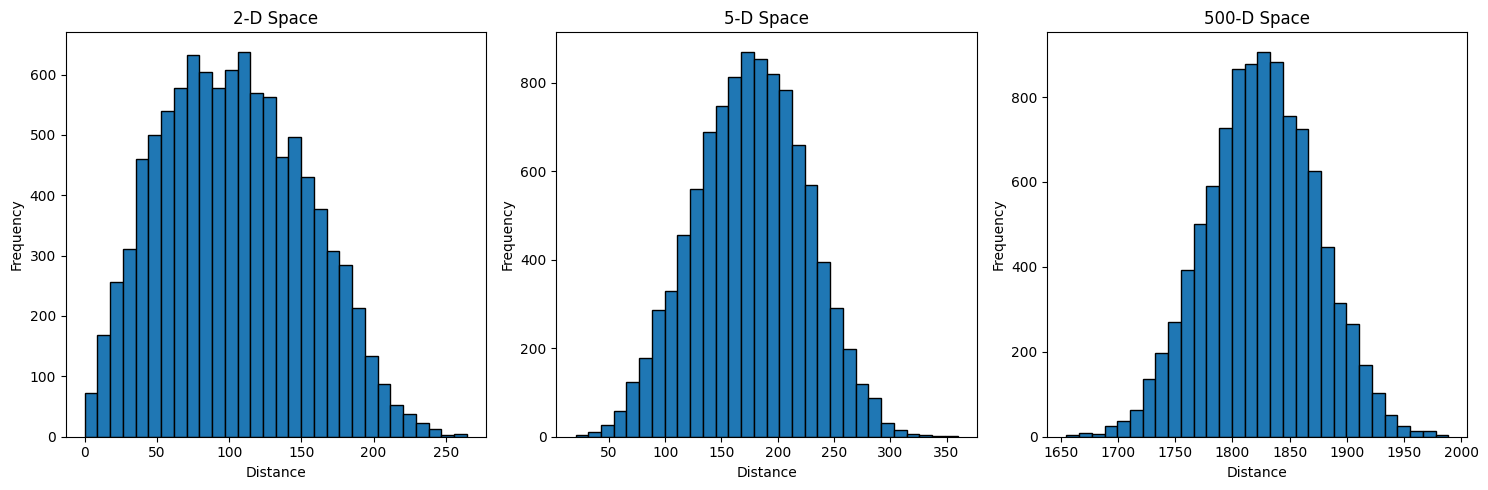

In [89]:
import numpy as np
import matplotlib.pyplot as plt

def generate_points(num_points, num_dimensions):
    return[np.random.randint(-100, 100, num_dimensions) for _ in range(num_points)]

def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def compute_pairwise_distances(points_x,points_y):
    distances = []
    for i,j in zip(points_x,points_y):
        distances.append(euclidean_distance(i,j))
    return np.array(distances)

# Set the number of points and dimensions
num_points = 10000

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through a few different dimensions
for ax, num_dimensions in zip(axes, [2, 5, 50]):
    # Generate points in unit hypercube
    points_x = generate_points(num_points, num_dimensions)
    points_y = generate_points(num_points, num_dimensions)

    # Compute pairwise distances
    distances = compute_pairwise_distances(points_x,points_y)
    
    # Plot histogram of distances
    ax.hist(distances, bins=30, edgecolor='black')
    ax.set_title(f"{num_dimensions}-D Space")
    ax.set_xlabel("Distance")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

### Exercise

1. Can you create a loop and evaluate the mean for dimensions from 0 - 500? 

---

###

However, observe that the relative differences between max an min in fact approach zero!

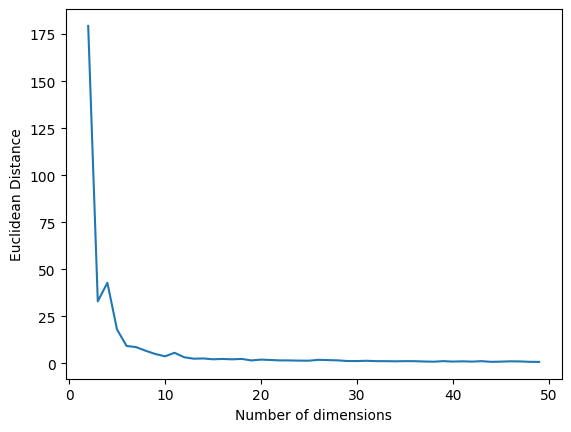

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math

deltas = []
for N in range(2,50):
    # Generate 1000 random points in N dimensions.
    P = [np.random.randint(-100, 100, N) for _ in range(10000)]
    Q = np.random.randint(-100,100,N)
    diffs = [np.linalg.norm(p-Q) for p in P]
    mxd = max(diffs)
    mnd = min(diffs)
    delta = (mxd-mnd)/mnd
    deltas.append( delta )

plt.plot(range(2,50),deltas)
plt.xlabel('Number of dimensions')
plt.ylabel('Euclidean Distance')
plt.show()

---
# Principle Components Analysis (PCA)

One way to reduce dimensionality is a principle components analysis (PCA).  PCA works by performing an eigenvector/eigenvalue decomposition of the data's covariance matrix. The goal is to transform the original features into a new set of uncorrelated features, known as principal components, which capture as much of the data's variance as possible. The first few principal components typically capture the majority of the variance, allowing for a lower-dimensional representation of the data.

### How does it work?

1. Center the data around the origin by subtracting the mean of each feature from the data points.

2. Calculate the covariance matrix, which captures how each feature varies with every other feature.

3. Compute the eigenvalues and eigenvectors of this covariance matrix. An eigenvector of a square matrix $A$ is a non-zero vector $\mathbf{v}$ that, when the matrix multiplies it, only scales the vector and does not change its direction. Mathematically, this can be written as $A\mathbf{v} = \lambda \mathbf{v}$

   Here, $A$ is the square matrix, $\mathbf{v}$ is the eigenvector, and $\lambda$ is the eigenvalue corresponding to this eigenvector. The eigenvalue controls how much the eigenvector is scaled. 
   
   **Intuition**: Imagine you have a rubber sheet that you can stretch, compress, or rotate. If you put an arrow (vector) on this sheet and then transform the sheet, most arrows would change both direction and length. However, some special arrows (eigenvectors) would only get "stretched" or "compressed" — they wouldn't change direction. The amount by which they get stretched or compressed is the eigenvalue. 

4. Eigenvalues are sorted in descending order, and the eigenvectors are rearranged correspondingly. The first eigenvalue will be the largest and indicates the maximum variance in the data that the first principal component (the corresponding eigenvector) captures.

5. To reduce dimensions, you can now select the first $k$ eigenvectors, where $k$ is the number of dimensions you want in your reduced dataset. You then project your original, centered data into this new \(k\)-dimensional subspace.

6. You can approximate the original data from the reduced data by projecting it back onto the original high-dimensional space by multiplying (dot-product) the transformed data with the transpose of the reduced eigenvector matrix.

### A Simple Example

First, we'll set up some sample data

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Step 1: Create synthetic 2D data
np.random.seed(0)
X = np.dot(np.random.rand(2, 2), np.random.randn(2, 200)).T

Now, the PCA, and the reconstruction:

In [17]:

# Step 2: Apply PCA and plot the rotated data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Step 3: Apply PCA and plot the rotated data
X_reduced = PCA(n_components=1).fit_transform(X)
X_reconstructed = PCA(n_components=1).fit(X).inverse_transform(X_reduced)


Finally, plotting:

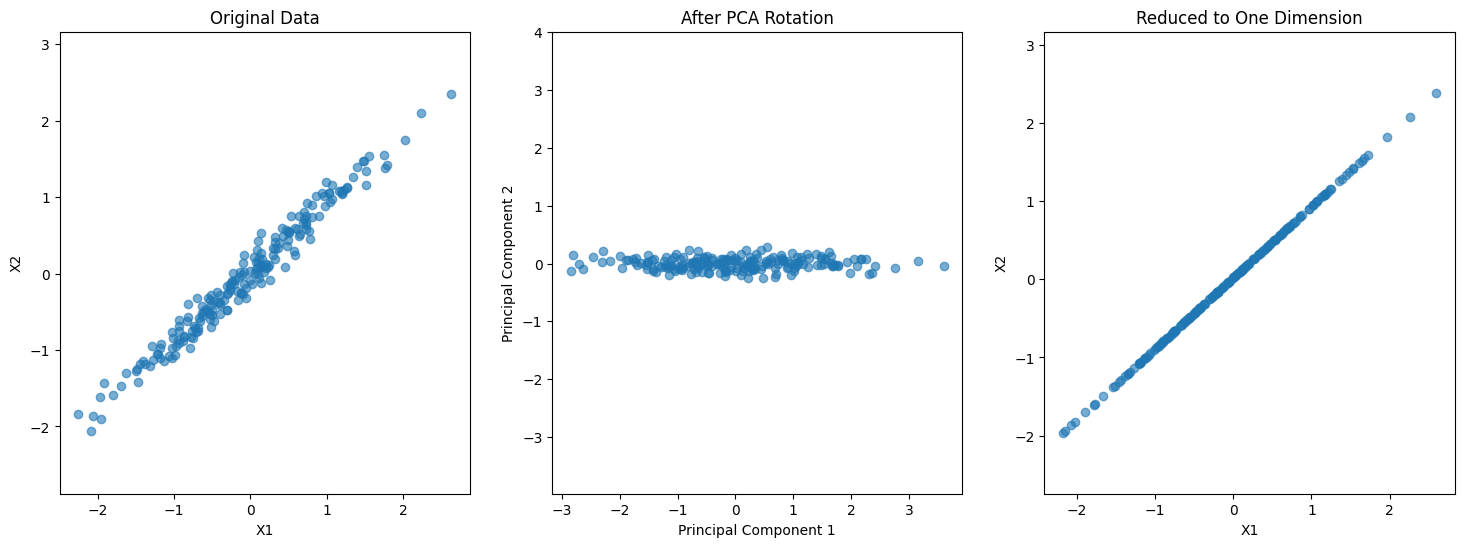

In [18]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(X[:, 0], X[:, 1], alpha=0.6)
plt.title("Original Data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.axis('equal')



plt.subplot(1, 3, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6)
plt.title("After PCA Rotation")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.axis('equal')

plt.subplot(1, 3, 3)
plt.scatter(X_reconstructed[:, 0], X_reconstructed[:, 1], alpha=0.6)
plt.title("Reduced to One Dimension")
plt.xlabel("X1")
plt.ylabel("X2")
plt.axis('equal')

plt.show()

### Selecting the right number of components

To select the right number of components, we can use the eigenvalues to calculate the amount of variance explained.  The variance explained by each principal component is directly related to the eigenvalues of the covariance matrix of the original dataset. Specifically, the proportion of variance explained by the $i^{th}$ principal component is given by:

$$
\text{Variance Explained}_i = \frac{\lambda_i}{\sum_{j=1}^{n} \lambda_j}
$$

where $\lambda_i$ is the eigenvalue corresponding to the $i^{th}$ principal component and $n$ is the number of components.

The eigenvalues are stored in decreasing order, and they measure the amount of variance along each principal component. A larger eigenvalue indicates that more variance is explained by that principal component.  We can visualize variance explained using a scree plot, and use the "elbow" method to select the number of components.

Variance Explained per Principal Component: [7.92556233e-01 7.41478585e-02 5.24005453e-02 3.51199136e-02
 2.11433667e-02 1.56168523e-02 4.84778213e-03 2.69208636e-03
 1.29776686e-03 1.77595141e-04]


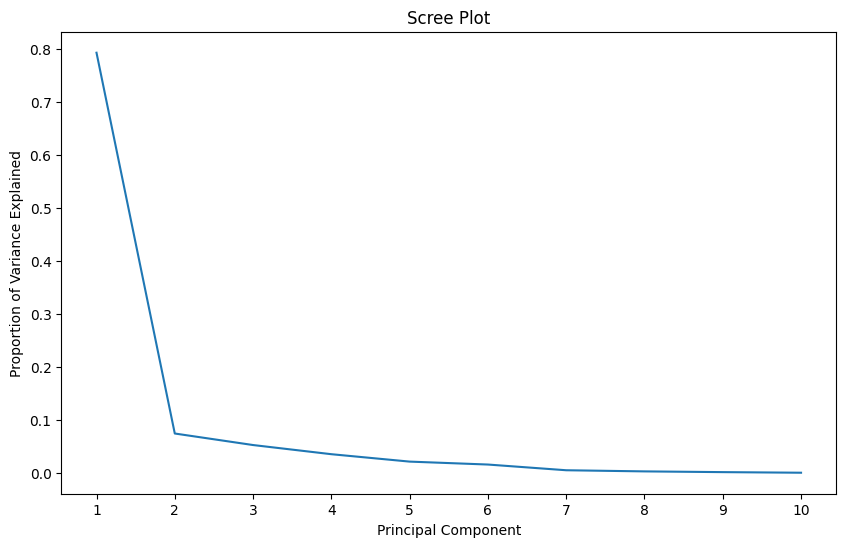

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Step 1: Create synthetic 10D data
np.random.seed(0)
X_high_dim = np.dot(np.random.rand(10, 10), np.random.randn(10, 200)).T

# Step 2: Apply PCA
pca_high_dim = PCA()  # although you can specify n_components, leaving out this parameter returns all
X_pca_high_dim = pca_high_dim.fit_transform(X_high_dim)

# Step 3: Calculate Variance Explained
variance_explained = pca_high_dim.explained_variance_ratio_
print("Variance Explained per Principal Component:", variance_explained)

# Step 4: Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(variance_explained) + 1), variance_explained)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Scree Plot')
plt.xticks(range(1, len(variance_explained) + 1))
plt.show()

Alternatively, if you know how much variance you want to explain, you can easily calculate it like this:

In [24]:
# Calculate cumulative variance explained
cumulative_variance_explained = np.cumsum(pca_high_dim.explained_variance_ratio_)

# Find the number of components for desired explained variance
threshold = 0.95  # 95% variance
n_components = np.argmax(cumulative_variance_explained >= threshold) + 1
print(f"Number of components needed for {threshold*100}% variance: {n_components}")

Number of components needed for 95.0% variance: 4


Scikit learn also let's you specify the variance you want in advance and will automatically lift out the number of components you need.

In [25]:
pca_high_dim = PCA(threshold)  # although you can specify n_components, leaving out this parameter returns all
X_pca_high_dim_auto = pca_high_dim.fit_transform(X_high_dim)

print(f"Number of components retrieved for {threshold*100}% = {X_pca_high_dim_auto.shape[1]}")

Number of components retrieved for 95.0% = 4


## Example

The MNIST data contains a large sample of handwritten letters.  Each letter is a 28x28 (768) grid of pixels, so the data is quite high dimensional.  Try using PCA to visualize the data.  I'll get you started with a little code below/

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load MNIST data
mnist = fetch_openml("mnist_784", version=1)
X, y = mnist["data"].values, mnist["target"].astype(int).values

# Sample the dataset to speed up computation (Optional)
X, y = X[:7000], y[:7000]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Visualize using PCA (2 components)
# Reduc the data with PCA

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train, cmap="jet")
plt.colorbar()
plt.title("MNIST - 2D PCA")
plt.show()


Now the scree plot...

In [ ]:

# Step 3: Scree Plot
pca_scree = None # What goes here???
# How do you get variance explained?
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")
plt.title("Scree Plot")
plt.show()


Choose the number of components to achieve 95% variance:

In [ ]:

# Step 4: Number of components for 95% variance
threshold = 0.95
n_components = None # What goes here???
print(f"Number of components for {threshold*100}% variance: {n_components}")

It's interesting to look at how a transform and reconstruction affects a single MNIST digit.  I've written a function to display a single digit.  Use PCA and the reconstruction method to have a look at this.  

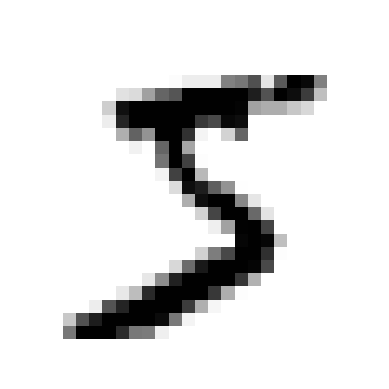

In [7]:
def plot_mnist_digit(digit):
    """Plot a single MNIST digit.

    Parameters:
    digit (numpy array): A flattened 1D numpy array of length 784.

    """
    # Reshape the flattened digit to 28x28 image
    digit_image = digit.reshape(28, 28)
    
    plt.imshow(digit_image, cmap='binary')
    plt.axis("off")
    plt.show()

plot_mnist_digit(X[0])

In [ ]:
# Use PCA with n_components to transform the above digit.  How does it look?

Use `n_components` to train a KNNClassifier, and compare accuracy to the non-reduced data.

In [ ]:
# Step 5: k-NN Classification
# Without PCA
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(f"Original Data Accuracy: {accuracy_score(y_test, y_pred)}")

# With PCA
# You have some work to do right here


y_pred_pca = None # How do you do this?
print(f"PCA-transformed Data Accuracy: {accuracy_score(y_test, y_pred_pca)}")


---

## Limitations of PCA

One of the key limitations of PCA is that it is a linear technique. This means that it works by finding new axes, called principal components, that are linear combinations of the original features. These principal components aim to capture as much variance in the data as possible. However, the linear nature of PCA imposes a limitation: it struggles to capture patterns in data that are fundamentally non-linear.

Imagine a dataset where points are distributed in a non-linear fashion, like a spiral or concentric circles. A linear method like PCA would not be able to capture the essence of such patterns. This is because the concept of "distance" or "variance" that PCA relies on does not adequately describe the intrinsic geometry of the data.

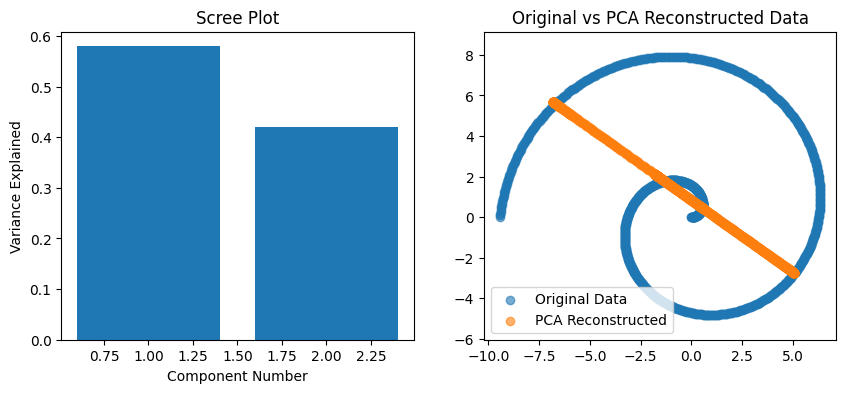

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Generate synthetic spiral data
n_points = 1000
n_turns = 3
t = np.linspace(0, n_turns * np.pi, n_points)
x = t * np.cos(t)
y = t * np.sin(t)

X_spiral = np.column_stack([x, y])

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_spiral)

# Scree Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.title("Scree Plot")
plt.xlabel("Component Number")
plt.ylabel("Variance Explained")

# Original Data vs PCA reconstruction
X_reduced = PCA(n_components=1).fit_transform(X_spiral)
X_reconstructed = PCA(n_components=1).fit(X_spiral).inverse_transform(X_reduced)

plt.subplot(1, 2, 2)
plt.scatter(X_spiral[:, 0], X_spiral[:, 1], alpha=0.6, label='Original Data')
plt.scatter(X_reconstructed[:, 0], X_reconstructed[:, 1], alpha=0.6, label='PCA Reconstructed')
plt.legend()
plt.axis('equal')
plt.title("Original vs PCA Reconstructed Data")

plt.show()


Thus, to determine the number of components you need for a 

### Determining the Number of Components to Achieve a Certain Level of Variance Explained

You can achieve a certain level of cumulative variance explained by summing the `explained_variance_ratio_` array until you reach the desired threshold. The following Python code snippet demonstrates how to find the number of components needed to capture, for example, 95% of the variance:

```python
import numpy as np
from sklearn.decomposition import PCA

# Generate synthetic 5D data
np.random.seed(0)
X_high_dim = np.dot(np.random.rand(5, 5), np.random.randn(5, 200)).T

# Apply PCA
pca_high_dim = PCA()
pca_high_dim.fit(X_high_dim)

# Calculate cumulative variance explained
cumulative_variance_explained = np.cumsum(pca_high_dim.explained_variance_ratio_)

# Find the number of components for desired explained variance
threshold = 0.95  # 95% variance
n_components = np.argmax(cumulative_variance_explained >= threshold) + 1
print(f"Number of components needed for {threshold*100}% variance: {n_components}")

# Optionally, you can transform the data into a lower-dimensional space
X_reduced = PCA(n_components=n_components).fit_transform(X_high_dim)
```

In this example, `n_components` will give you the smallest number of components required to capture at least 95% of the variance in the original dataset.

### Relationship Between Variance Explained and Eigenvalues

In PCA, 

The `explained_variance_` attribute of a fitted PCA object in scikit-learn actually gives you these eigenvalues (scaled by a factor, which cancels out when taking the ratio), so if you wanted to calculate the variance explained manually, you could do it like this:

```python
eigenvalues = pca_high_dim.explained_variance_
total_eigenvalue = np.sum(eigenvalues)
variance_explained_manual = eigenvalues / total_eigenvalue
```

This should yield the same result as using the `explained_variance_ratio_` attribute directly.

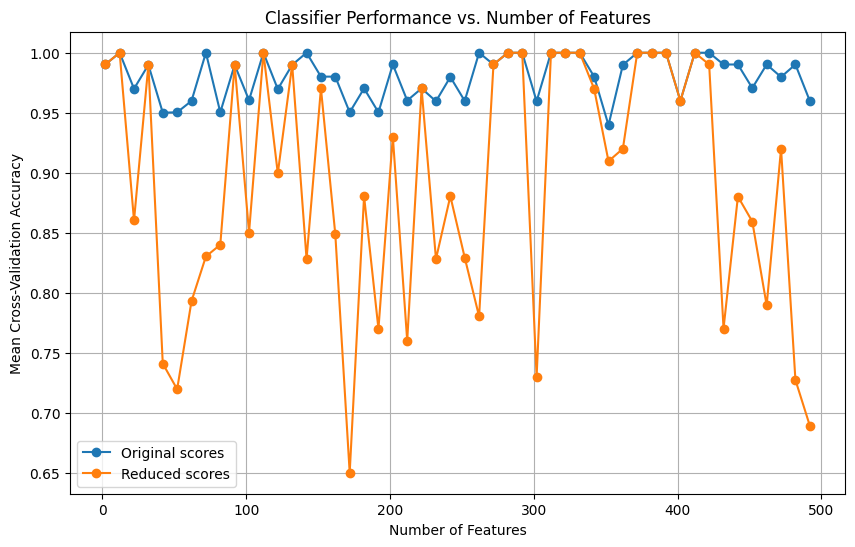

In [79]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
import numpy as np

# Initialize variables
n_samples = 100
n_classes = 2
scores = []
reduced_scores = []

# def generate_naive_data(n_samples=1000, n_features=50,separation=.2):
#     classA_data = np.random.rand(n_samples // 2, n_features)
#     #transformation_matrix_subset = np.random.dirichlet(alpha=np.ones(n_informative) * separation, size=n_informative)

#     random_vector = np.random.rand(1, n_features)
#     random_vector = random_vector - np.mean(random_vector)
#     #scaled_vector = (random_vector / np.sum(np.abs(random_vector))) * separation

#     # Replicate this row vector to create a matrix of the same shape as Class B data
#     scaled_matrix = np.tile(random_vector, (n_samples // 2, 1))

    
#     classB_data = np.random.rand(n_samples // 2, n_features)+scaled_matrix
#     #rotation = np.random.dirichlet(alpha=np.ones(n_features) * alpha, size=n_features)

#     #classB_data = classB_data.dot(rotation)

#     X = np.vstack((classA_data, classB_data))
#     y = np.hstack((np.zeros(n_samples // 2), np.ones(n_samples // 2)))
#     return X,y

def row_normalize(matrix):
    row_sums = matrix.sum(axis=1)[:, np.newaxis]
    return matrix / row_sums

def generate_linear_data(n_samples=1000, n_features=50, alpha = 1, separation=.5):
    """
    Generate synthetic data with two classes based on linear combinations of lower-dimensional data.
    
    Parameters:
        - n_samples: The total number of samples.
        - n_features: The number of features.
        - n_informative: The number of informative features upon which the higher dimensions are based.
        
    Returns:
        - X: The feature matrix.
        - y: The label vector.
    """
    
    
    classA_data = np.random.rand(n_samples // 2, n_features)
    noise = np.random.normal(scale=separation/n_features**1.4, size=(n_features, n_features))
    transformation_base = np.random.dirichlet(alpha=np.ones(n_features) * alpha, size=n_features)
    transformationA = row_normalize(transformation_base-noise)   
    

    classB_data = np.random.rand(n_samples // 2, n_features)
    transformationB = row_normalize(transformation_base+noise)


    # transformationB = np.random.dirichlet(alpha=np.ones(n_features) * separation, size=n_features)
    
    
    
   
    # Combine into one dataset
    X = np.vstack((classA_data.dot(transformationA), classB_data.dot(transformationB)))
    y = np.hstack((np.zeros(n_samples // 2), np.ones(n_samples // 2)))
    
    return X, y

def generate_linear_data2(n_samples=1000, n_features=50, alpha = 1, separation=.5):
    """
    Generate synthetic data with two classes based on linear combinations of lower-dimensional data.
    
    Parameters:
        - n_samples: The total number of samples.
        - n_features: The number of features.
        - n_informative: The number of informative features upon which the higher dimensions are based.
        
    Returns:
        - X: The feature matrix.
        - y: The label vector.
    """
    
    
    classA_data = np.random.rand(n_samples // 2, n_features)
    classB_data = np.random.rand(n_samples // 2, n_features)
    
    transformation_base = np.zeros(n_features)
    transformation_base[:min(n_features,10)] = 1  # First 10 features are informative

    # Apply some random variations
    transformation_base += np.random.normal(0, 0.1, n_features)

    # Normalize
    transformation_base = transformation_base / np.sum(transformation_base)

    # Create two transformation matrices
    noise = np.random.normal(0, separation, n_features)
    transformationA = transformation_base + noise
    transformationB = transformation_base - noise

    # Normalize again
    transformationA = np.tile(transformationA / np.sum(transformationA),(n_features,1))
    transformationB = np.tile(transformationB / np.sum(transformationB),(n_features,1))
   
    # Combine into one dataset
    X = np.vstack((classA_data.dot(transformationA), classB_data.dot(transformationB)))
    y = np.hstack((np.zeros(n_samples // 2), np.ones(n_samples // 2)))
    
    return X, y

# Loop through different numbers of features
for n_features in range(2, 500, 10):  # Increasing features from 2 to 100 in steps of 5
    # Generate synthetic data
    #X, y = generate_synthetic_data(n_features = n_features, noise_level=.5, separability=.1)
    X, y = generate_linear_data2(n_samples=n_samples,n_features = n_features, alpha = .1, separation=2)
    #X, y = generate_naive_data(n_samples=n_samples,n_features = n_features,separation=5)
    
    # Initialize and train classifier
    #knn = KNeighborsClassifier()
    knn = KNeighborsClassifier()

    # Evaluate classifier using 5-fold cross-validation
    score = np.mean(cross_val_score(knn, X, y, cv=3, scoring='accuracy'))
    scores.append(score)


    # Now with PCA:
    pipeline = make_pipeline(PCA(n_components=.95),knn)
    reduced_score = np.mean(cross_val_score(pipeline, X, y, cv=3, scoring='accuracy'))
    reduced_scores.append(reduced_score)
    

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(2, 500, 10), scores, marker='o', label="Original scores")
plt.plot(range(2, 500, 10), reduced_scores, marker='o', label="Reduced scores")
plt.title('Classifier Performance vs. Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [78]:
x,y = generate_linear_data2(n_samples=5,n_features=10)
print(x)
print(y)


[[ 0.32   0.346]
 [10.094 38.091]]
[0. 0. 1. 1.]


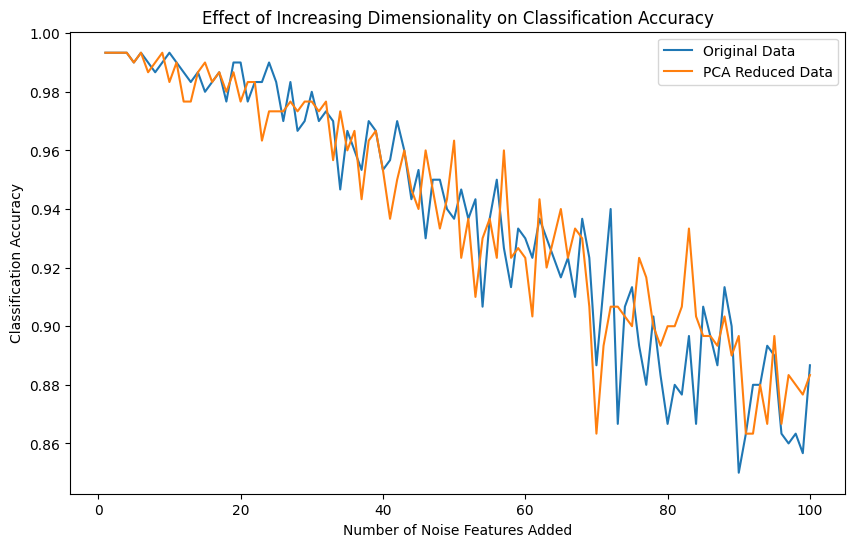

In [7]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Generate base synthetic data
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           n_clusters_per_class=1, n_classes=2, n_samples=1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize lists to hold accuracies
original_accuracies = []
reduced_accuracies = []

# Step 2 & 3: Add noise features and evaluate classifier
for i in range(1, 101):  # Adding up to 50 noise features
    noise = np.random.normal(size=(X_train.shape[0], i))
    X_train_noise = np.hstack([X_train, noise])
    
    noise = np.random.normal(size=(X_test.shape[0], i))
    X_test_noise = np.hstack([X_test, noise])
    
    knn = KNeighborsClassifier()
    knn.fit(X_train_noise, y_train)
    y_pred = knn.predict(X_test_noise)
    
    acc = accuracy_score(y_test, y_pred)
    original_accuracies.append(acc)

# Step 4: Apply dimensionality reduction and re-evaluate
from sklearn.decomposition import PCA

for i in range(1, 101):
    noise = np.random.normal(size=(X_train.shape[0], i))
    X_train_noise = np.hstack([X_train, noise])
    
    noise = np.random.normal(size=(X_test.shape[0], i))
    X_test_noise = np.hstack([X_test, noise])
    
    pca = PCA(n_components=.95)
    X_train_reduced = pca.fit_transform(X_train_noise)
    X_test_reduced = pca.transform(X_test_noise)
    
    knn = KNeighborsClassifier()
    knn.fit(X_train_reduced, y_train)
    y_pred = knn.predict(X_test_reduced)
    
    acc = accuracy_score(y_test, y_pred)
    reduced_accuracies.append(acc)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), original_accuracies, label='Original Data')
plt.plot(range(1, 101), reduced_accuracies, label='PCA Reduced Data')
plt.xlabel('Number of Noise Features Added')
plt.ylabel('Classification Accuracy')
plt.title('Effect of Increasing Dimensionality on Classification Accuracy')
plt.legend()
plt.show()

In [10]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create a synthetic dataset with a large number of features
X, y = make_classification(n_samples=1000, n_features=1000, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Evaluate the classifier's accuracy on the test data
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy before PCA: {accuracy}")

# Apply PCA to reduce dimensionality
pca = PCA(n_components=50)  # Reduce to 50 principal components
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a classifier on the reduced data
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_pca, y_train)

# Evaluate the classifier's accuracy on the test data
y_pred = clf.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy after PCA: {accuracy}")


Accuracy before PCA: 0.86
Accuracy after PCA: 0.73
